# Trading Signal Generation

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.manifold import TSNE
import os

pd.set_option('display.max_colwidth', None)

## Preprocessing

In [2]:
file_path = "data/processed/labeled_january_data.csv"

with open(file_path, "r", encoding="utf-8") as file:
    df_jan = pd.read_csv(file)

In [3]:
file_path = "data/processed/labeled_february_data.csv"

with open(file_path, "r", encoding="utf-8") as file:
    df_feb = pd.read_csv(file)

In [4]:
import spacy

# spacy PT model
nlp = spacy.load('pt_core_news_sm')

#preprocessing
def preprocess_text_spacy(text):
    doc = nlp(text)
    
    # lemmatization and stopwords removal
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    
    #tokens back to 1 string
    return ' '.join(tokens)

# preprocess ALL articles in january's dataframe
df_jan['preprocessed_article'] = df_jan['article'].apply(preprocess_text_spacy)
df_feb['preprocessed_article'] = df_feb['article'].apply(preprocess_text_spacy)


## Applying the Word2Vec approach

In [5]:
from gensim.models import Word2Vec

# Prepare tokenized articles
tokenized_articles = df_jan['preprocessed_article'].apply(str.split).tolist() + \
                     df_feb['preprocessed_article'].apply(str.split).tolist()

# Train Word2Vec
word2vec_model = Word2Vec(
    sentences=tokenized_articles,
    vector_size=300,  # Embedding dimensionality
    window=5,         # Context window size
    min_count=5,      # Minimum word frequency
    sg=1,             # Skip-gram method
    workers=4,        # Number of threads
    epochs=20         # Number of training iterations
)

# Save Word2Vec model
word2vec_model.save("models/word2vec_enhanced.model")
print("Word2Vec model saved.")

Word2Vec model saved.


In [6]:
import numpy as np

def vectorize_article(text, model):
    """
    Generate a document vector by averaging word embeddings.
    :param text: Preprocessed article as a string.
    :param model: Trained Word2Vec model.
    :return: Document vector (numpy array).
    """
    tokens = text.split()
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

# Generate embeddings for both datasets
df_jan['embedding'] = df_jan['preprocessed_article'].apply(lambda x: vectorize_article(x, word2vec_model))
df_feb['embedding'] = df_feb['preprocessed_article'].apply(lambda x: vectorize_article(x, word2vec_model))

# Save datasets with embeddings
df_jan.to_pickle("data/processed/january_with_embeddings.pkl")
df_feb.to_pickle("data/processed/february_with_embeddings.pkl")
print("Datasets with embeddings saved.")

Datasets with embeddings saved.


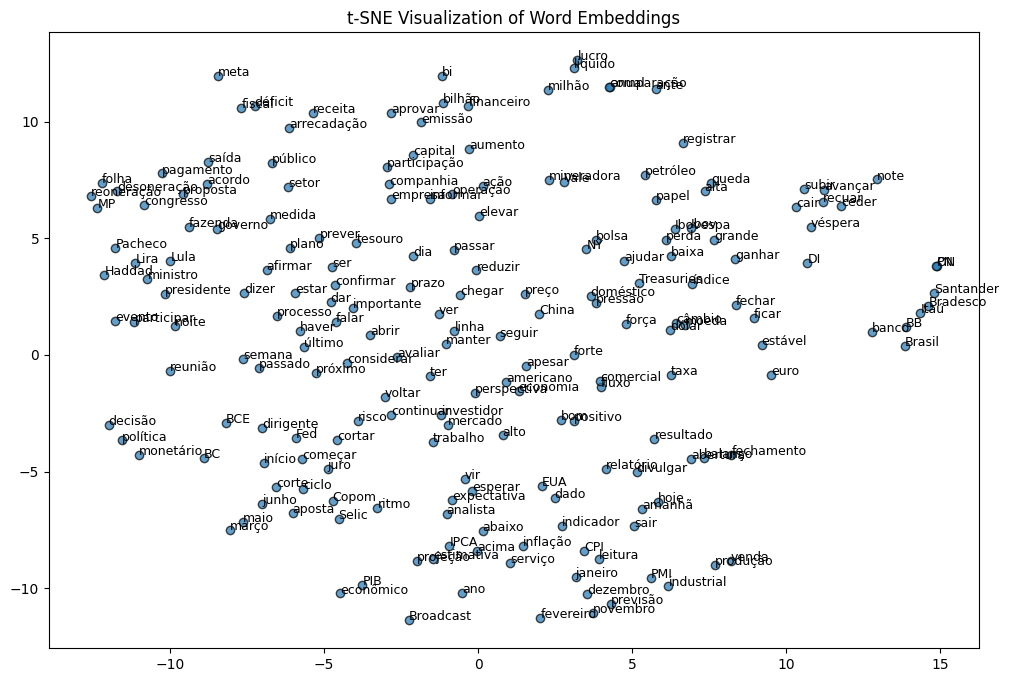

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Get most frequent words
most_frequent_words = word2vec_model.wv.index_to_key[:200]  # Top 200 words
word_vectors = np.array([word2vec_model.wv[word] for word in most_frequent_words])

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
word_embeddings_2d = tsne.fit_transform(word_vectors)

# Plot t-SNE visualization
plt.figure(figsize=(12, 8))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], alpha=0.7, edgecolors='k')
for i, word in enumerate(most_frequent_words):
    plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]), fontsize=9)
plt.title('t-SNE Visualization of Word Embeddings')
plt.savefig("results/word2vec_tsne_visualization.png")
plt.show()

In [8]:
def balance_dataset(df, target_column, labels, samples_per_label):
    """
    Balance the dataset by selecting an equal number of samples for each label.
    """
    balanced_dfs = [
        df[df[target_column] == label].sample(n=samples_per_label, random_state=42)
        for label in labels
    ]
    return pd.concat(balanced_dfs).reset_index(drop=True)

# Balance multi-class training/testing datasets
samples_per_label_jan_mc = min(df_jan['label'].value_counts())
samples_per_label_feb_mc = min(df_feb['label'].value_counts())

df_jan_multiclass = balance_dataset(df_jan, 'label', [1, 0, -1], samples_per_label_jan_mc)
df_feb_multiclass = balance_dataset(df_feb, 'label', [1, 0, -1], samples_per_label_feb_mc)

# Balance binary training/testing datasets
samples_per_label_jan_bin = min(df_jan[df_jan['label'].isin([1, -1])]['label'].value_counts())
samples_per_label_feb_bin = min(df_feb[df_feb['label'].isin([1, -1])]['label'].value_counts())

df_jan_binary = balance_dataset(df_jan, 'label', [1, -1], samples_per_label_jan_bin)
df_feb_binary = balance_dataset(df_feb, 'label', [1, -1], samples_per_label_feb_bin)

# Save balanced datasets
df_jan_multiclass.to_pickle("data/processed/january_multiclass_balanced.pkl")
df_feb_multiclass.to_pickle("data/processed/february_multiclass_balanced.pkl")
df_jan_binary.to_pickle("data/processed/january_binary_balanced.pkl")
df_feb_binary.to_pickle("data/processed/february_binary_balanced.pkl")
print("Balanced datasets saved.")

Balanced datasets saved.


C:\Users\scaro\AppData\Local\Temp\ipykernel_19416\3416928091.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_jan_multiclass, x='label', palette='viridis')


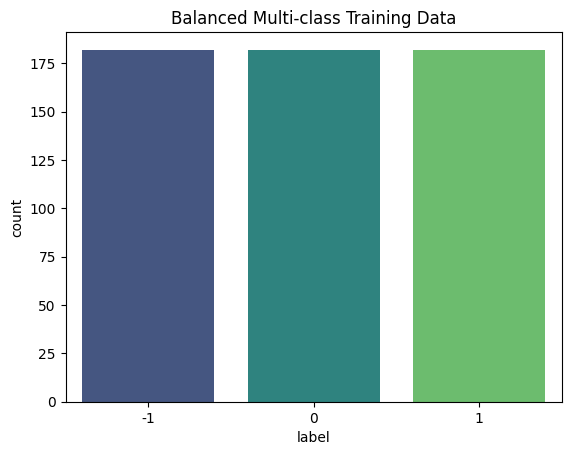

C:\Users\scaro\AppData\Local\Temp\ipykernel_19416\3416928091.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_feb_binary, x='label', palette='viridis')


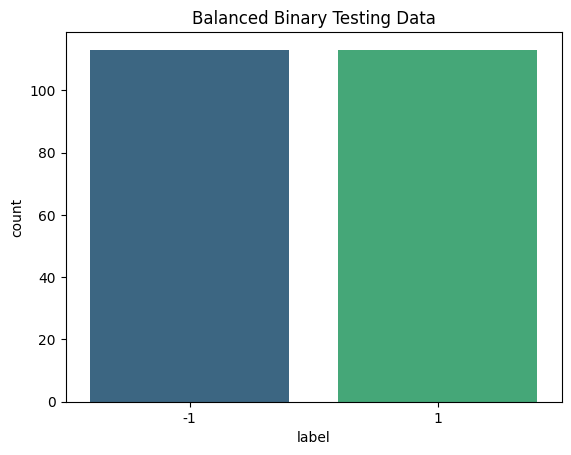

In [9]:
sns.countplot(data=df_jan_multiclass, x='label', palette='viridis')
plt.title('Balanced Multi-class Training Data')
plt.savefig("results/multiclass_training_label_distribution.png")
plt.show()

sns.countplot(data=df_feb_binary, x='label', palette='viridis')
plt.title('Balanced Binary Testing Data')
plt.savefig("results/binary_testing_label_distribution.png")
plt.show()

## Visualising the distribution of the Target variable
- helps us to realize a class imbalance
- good to keep track of
- MOVE THIS INTO the PREPROCESSING file eventually

In [ ]:
sns.countplot(x='label', data=df_jan)
plt.title('Label Distribution in January Dataset')
plt.savefig("results/label_distribution_january.png")
plt.show()

In [ ]:
sns.countplot(x='label', data=df_feb)
plt.title('Label Distribution in February Dataset')
plt.savefig("results/label_distribution_february.png")
plt.show()

In [ ]:
# January

import pandas as pd

file_path = 'data/processed/labeled_january_data.csv'
df_jan = pd.read_csv(file_path)

column_data = df_jan['label']
counts = column_data.value_counts()

count_1 = counts[1]
count_minus_1 = counts[-1]
count_0 = counts[0]

print("January\n")
print(f"Count of 1: {count_1}")
print(f"Count of -1: {count_minus_1}")
print(f"Count of 0: {count_0}")
print(f"Total Number of Articles: {count_1 + count_minus_1 + count_0}")

In [ ]:
# February

import pandas as pd

file_path = 'data/processed/labeled_february_data.csv'
df = pd.read_csv(file_path)

column_name = 'label'
column_data = df[column_name]

counts = column_data.value_counts()

count_1 = counts[1]
count_minus_1 = counts[-1]
count_0 = counts[0]


print("February\n")
print(f"Count of 1: {count_1}")
print(f"Count of -1: {count_minus_1}")
print(f"Count of 0: {count_0}")
print(f"Total Number of Articles: {count_1 + count_minus_1 + count_0}")

## Multinomial Logistic Regression Model with Custom Word2Vec Model

Task: 
- Train on January, test on first 2 weeks of February respectively
    - Train / test with 3 classes (+1, 0, -1), yielding a 3 x 3 confusion matrix
    - Train / test with 2 classes (+1, -1), yielding a 2 x 2 confusion matrix
- Apply softmax to improve accuracy if poor

In [16]:
import pandas as pd
import numpy as np

# Load balanced datasets
df_jan_multiclass = pd.read_pickle("data/processed/january_multiclass_balanced.pkl")
df_feb_multiclass = pd.read_pickle("data/processed/february_multiclass_balanced.pkl")
df_jan_binary = pd.read_pickle("data/processed/january_binary_balanced.pkl")
df_feb_binary = pd.read_pickle("data/processed/february_binary_balanced.pkl")

# Prepare features and labels
X_train_mc = np.vstack(df_jan_multiclass['embedding'])
y_train_mc = df_jan_multiclass['label']

X_test_mc = np.vstack(df_feb_multiclass['embedding'])
y_test_mc = df_feb_multiclass['label']

X_train_bin = np.vstack(df_jan_binary['embedding'])
y_train_bin = df_jan_binary['label']

X_test_bin = np.vstack(df_feb_binary['embedding'])
y_test_bin = df_feb_binary['label']

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest for multi-class classification
clf_mc = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf_mc.fit(X_train_mc, y_train_mc)
print("Multi-class Random Forest model trained.")

Multi-class Random Forest model trained.


In [18]:
# Train Random Forest for binary classification
clf_bin = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf_bin.fit(X_train_bin, y_train_bin)
print("Binary Random Forest model trained.")

Binary Random Forest model trained.


In [19]:
# Multi-class predictions
y_pred_mc = clf_mc.predict(X_test_mc)

# Binary predictions
y_pred_bin = clf_bin.predict(X_test_bin)

In [20]:
from sklearn.metrics import classification_report

# Multi-class report
report_mc = classification_report(y_test_mc, y_pred_mc, target_names=["+1", "0", "-1"])
print("Multi-class Classification Report:")
print(report_mc)
with open("results/multiclass_classification_report.txt", "w") as f:
    f.write(report_mc)

# Binary report
report_bin = classification_report(y_test_bin, y_pred_bin, target_names=["+1", "-1"])
print("Binary Classification Report:")
print(report_bin)
with open("results/binary_classification_report.txt", "w") as f:
    f.write(report_bin)

Multi-class Classification Report:
              precision    recall  f1-score   support

          +1       0.40      0.50      0.44       113
           0       0.59      0.50      0.55       113
          -1       0.42      0.38      0.40       113

    accuracy                           0.46       339
   macro avg       0.47      0.46      0.46       339
weighted avg       0.47      0.46      0.46       339

Binary Classification Report:
              precision    recall  f1-score   support

          +1       0.52      0.58      0.55       113
          -1       0.52      0.47      0.50       113

    accuracy                           0.52       226
   macro avg       0.52      0.52      0.52       226
weighted avg       0.52      0.52      0.52       226



In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#  visualize the multi-class confusion matrix
cm_multiclass = confusion_matrix(y_test_mc, y_pred_mc, labels=[1, 0, -1])
disp_multiclass = ConfusionMatrixDisplay(confusion_matrix=cm_multiclass, display_labels=["+1", "0", "-1"])
fig, ax = plt.subplots(figsize=(8, 6))
disp_multiclass.plot(ax=ax, cmap='Greys')  
ax.set_title("Confusion Matrix for Multi-class Classification", fontsize=14)
plt.tight_layout()
plt.savefig("results/multiclass_confusion_matrix.png", dpi=300)
plt.show()

#  visualize the binary confusion matrix
cm_binary = confusion_matrix(y_test_bin, y_pred_bin, labels=[1, -1])
disp_binary = ConfusionMatrixDisplay(confusion_matrix=cm_binary, display_labels=["+1", "-1"])
fig, ax = plt.subplots(figsize=(8, 6))
disp_binary.plot(ax=ax, cmap='Greys')  
ax.set_title("Confusion Matrix for Binary Classification", fontsize=14)
plt.tight_layout()
plt.savefig("results/binary_confusion_matrix.png", dpi=300)
plt.show()

SyntaxError: invalid syntax (4008166266.py, line 23)

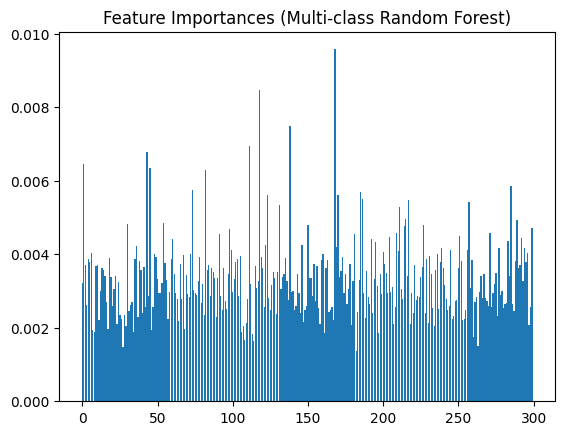

In [22]:
# get feature importances from the model for multi class stuff
feature_importances_mc = clf_mc.feature_importances_

# Plot feature importances for multi class stuff
plt.bar(range(len(feature_importances_mc)), feature_importances_mc)
plt.title("Feature Importances (Multi-class Random Forest)")
plt.savefig("results/multiclass_feature_importances.png")
plt.show()

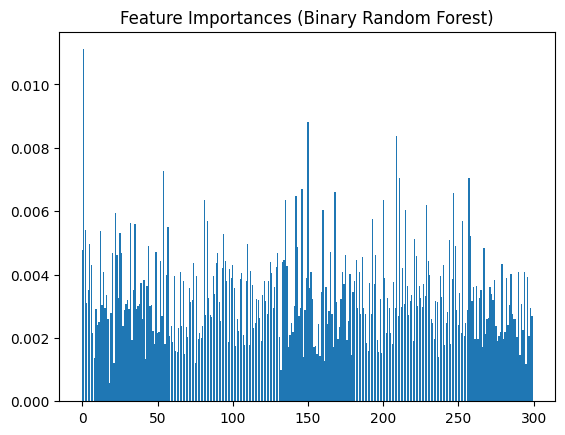

In [23]:
#  feature importances from the model for binary class stuff
feature_importances_bin = clf_bin.feature_importances_

# plot feature importances for binary class stuff
plt.bar(range(len(feature_importances_bin)), feature_importances_bin)
plt.title("Feature Importances (Binary Random Forest)")
plt.savefig("results/binary_feature_importances.png")
plt.show()

In [26]:
import pickle

# Save multi-class model
with open("models/multiclass_random_forest.pkl", "wb") as f:
    pickle.dump(clf_mc, f)

# Save binary model
with open("models/binary_random_forest.pkl", "wb") as f:
    pickle.dump(clf_bin, f)

print("Random Forest models saved.")

Random Forest models saved.


# GPT Generated code to test the pipeline for a news headline that Beakal can enter every minute

In [ ]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
import pickle

# Load trained Word2Vec model
word2vec_model = Word2Vec.load("models/word2vec_enhanced.model")

# Load trained Random Forest models
with open("models/multiclass_random_forest.pkl", "rb") as f:
    clf_mc = pickle.load(f)

with open("models/binary_random_forest.pkl", "rb") as f:
    clf_bin = pickle.load(f)

# Define preprocessing function
def preprocess_input(text):
    """
    Preprocess a raw Portuguese text input to match the format used during training.
    This function should include the same steps as your preprocessing pipeline.
    """
    # Example basic preprocessing steps (adjust as needed for your data)
    import re
    from nltk.corpus import stopwords
    
    # Define Portuguese stopwords
    stopwords_pt = set(stopwords.words("portuguese"))
    
    # Lowercase, remove punctuation and stopwords
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = [word for word in text.split() if word not in stopwords_pt]
    return tokens

# Define function to classify a headline
def classify_headline(headline):
    """
    Classify an inputted Portuguese news headline using the trained models.
    :param headline: Raw text headline in Portuguese
    :return: Multi-class and binary classification results
    """
    # Preprocess the headline
    tokens = preprocess_input(headline)
    
    # Generate document embedding
    embedding = np.mean([word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv], axis=0)
    if embedding.shape == ():
        embedding = np.zeros(word2vec_model.vector_size)
    
    # Reshape for model input
    embedding = embedding.reshape(1, -1)
    
    # Get classifications
    multi_class_label = clf_mc.predict(embedding)[0]
    binary_label = clf_bin.predict(embedding)[0]
    
    # Map labels to descriptions
    multi_class_map = {1: "Good for BRL (+1)", 0: "Neutral (0)", -1: "Bad for BRL (-1)"}
    binary_class_map = {1: "Good for BRL (+1)", -1: "Bad for BRL (-1)"}
    
    return {
        "multi_class": multi_class_map[multi_class_label],
        "binary_class": binary_class_map[binary_label],
    }

# Example usage, should outputt +1 cause it's positive
example_headline = "Taxa de juros do Brasil aumenta, fortalecendo o real"
result = classify_headline(example_headline)
print(f"Input headline: {example_headline}")
print(f"Multi-class classification: {result['multi_class']}")
print(f"Binary classification: {result['binary_class']}")

Input headline: Taxa de juros do Brasil aumenta, fortalecendo o real
Multi-class classification: Good for BRL (+1)
Binary classification: Good for BRL (+1)
